# Exploratory Analysis of Synthetic Panel Data

This notebook provides a brief exploratory analysis of the synthetic panel dataset generated in this repository.

The goals are to:

- Inspect the structure and summary statistics of the data  
- Visualize outcomes over time for treated vs. control units  
- Build intuition for the difference in differences (DiD) setup  

The dataset was generated by `generate_data.py` and saved to `data/processed/sim_panel.csv`.  
Each row corresponds to a unit–time observation with:

- `unit_id`: unit identifier (e.g., firm or region)  
- `time`: time period (integer)  
- `treated`: 1 if the unit is ever treated, 0 otherwise  
- `post`: 1 if the period is after the policy starts, 0 otherwise  
- `treat_post`: interaction of `treated * post` (the DiD term)  
- `x1`, `x2`: additional covariates  
- `y`: outcome variable  

## Imports & Settings

In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Make plots a bit bigger by default
plt.rcParams["figure.figsize"] = (8, 5)

# Show pandas floats with fewer decimals for readability
pd.options.display.float_format = "{:.3f}".format

## Load Data

In [2]:
# Construct path to the processed data
notebook_dir = os.path.dirname(os.getcwd())  # parent of notebooks/
data_path = os.path.join(notebook_dir, "data", "processed", "sim_panel.csv")

print("Loading data from:", data_path)
df = pd.read_csv(data_path)

df.head()

Loading data from: d:\GitHub\coding-sample\data\processed\sim_panel.csv


,unit_id,time,treated,post,treat_post,x1,x2,y
0,1,1,0,0,0,1.191,0.263,3.922
1,1,2,0,0,0,-1.745,0.927,2.529
2,1,3,0,0,0,-1.110,-0.472,3.376
3,1,4,0,0,0,0.052,-0.292,3.836
4,1,5,0,0,0,-0.252,0.153,5.425


## Quick Data Description

## Basic Structure and Summary

We start by checking:

- The number of units and time periods  
- The balance of treated vs. control units  
- Basic summary statistics for the main variables  

## Shape, Unique Counts, Summary Stats

In [3]:
n_rows, n_cols = df.shape
n_units = df["unit_id"].nunique()
n_periods = df["time"].nunique()

print(f"Rows: {n_rows}, Columns: {n_cols}")
print(f"Unique units: {n_units}")
print(f"Unique time periods: {n_periods}")

print("\nTreated vs. control units (count):")
print(df.groupby("treated")["unit_id"].nunique())

print("\nSummary statistics:")
df[["y", "treated", "post", "treat_post", "x1", "x2"]].describe()

Rows: 2000, Columns: 8
Unique units: 200
Unique time periods: 10

Treated vs. control units (count):
treated
0    120
1     80
Name: unit_id, dtype: int64

Summary statistics:


,y,treated,post,treat_post,x1,x2
count,2000.000,2000.000,2000.000,2000.000,2000.000,2000.000
mean,3.811,0.400,0.500,0.200,-0.023,0.020
std,1.886,0.490,0.500,0.400,1.023,0.983
min,-2.407,0.000,0.000,0.000,-4.389,-3.110
25%,2.492,0.000,0.000,0.000,-0.714,-0.635
50%,3.772,0.000,0.500,0.000,0.010,0.008
75%,5.158,1.000,1.000,0.000,0.645,0.703
max,10.257,1.000,1.000,1.000,3.241,3.208


## Average Outcome Over Time by Treatment Status

To build intuition for the DiD setting, we plot average outcomes over time separately for:

- Units that are **ever treated** (`treated = 1`)  
- Units that are **never treated** (`treated = 0`)  

In a typical DiD setup, we are interested in whether the treated units experience a differential change in outcomes after the policy starts, relative to the control units.

## Compute Group Means and Plot

In [4]:
# Compute mean outcome by time and treatment status
mean_y = (
    df.groupby(["time", "treated"])["y"]
    .mean()
    .reset_index()
    .pivot(index="time", columns="treated", values="y")
)

mean_y.columns = ["control_mean_y", "treated_mean_y"]
mean_y

,control_mean_y,treated_mean_y
time,,
1,2.271,2.112
2,2.599,2.516
3,2.992,2.729
4,2.950,3.004
5,3.432,3.391
6,3.970,4.629
7,3.945,5.129
8,4.390,5.359
9,4.820,5.832


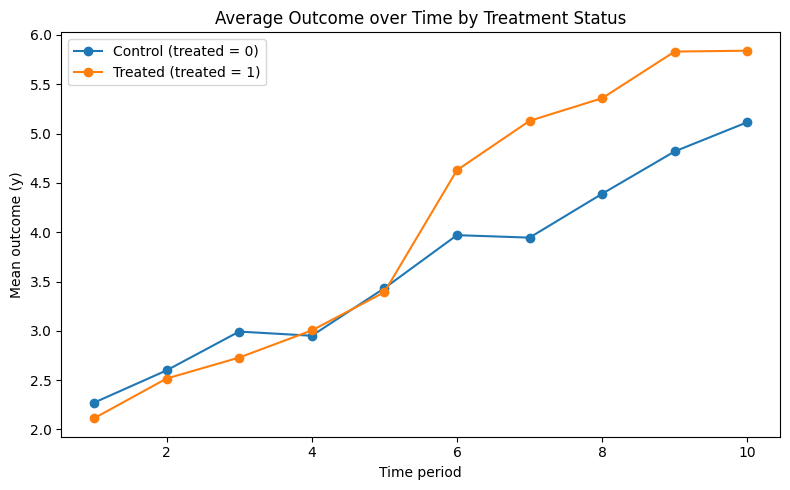

In [5]:
# Line plot of average outcome over time for treated vs control
ax = mean_y.plot(marker="o")
ax.set_title("Average Outcome over Time by Treatment Status")
ax.set_xlabel("Time period")
ax.set_ylabel("Mean outcome (y)")
ax.legend(["Control (treated = 0)", "Treated (treated = 1)"])
plt.tight_layout()
plt.show()

## Pre vs Post Policy Comparison

Next, we look at how average outcomes change **before** and **after** the policy:

- For treated units  
- For control units  

This connects directly to the DiD intuition.

In [6]:
# Average outcome by treated x post
pre_post_summary = (
    df.groupby(["treated", "post"])["y"]
    .mean()
    .reset_index()
    .pivot(index="treated", columns="post", values="y")
)

pre_post_summary.columns = ["pre_policy_mean_y", "post_policy_mean_y"]
pre_post_summary.index = ["control (0)", "treated (1)"]

pre_post_summary

,pre_policy_mean_y,post_policy_mean_y
control (0),2.849,4.448
treated (1),2.750,5.358


In [7]:
# Compute simple differences
pre_post_summary["change"] = (
    pre_post_summary["post_policy_mean_y"] - pre_post_summary["pre_policy_mean_y"]
)
pre_post_summary

,pre_policy_mean_y,post_policy_mean_y,change
control (0),2.849,4.448,1.599
treated (1),2.750,5.358,2.608


## Connecting to Difference in Differences

From the table above:

- The change for control units captures background trends over time  
- The change for treated units reflects both background trends and the policy effect  

The difference-in-differences estimate is computed as:

(change in average outcome for treated units)
minus
(change in average outcome for control units).

Below we compute this quantity directly from the summary table.

In [8]:
delta_control = pre_post_summary.loc["control (0)", "change"]
delta_treated = pre_post_summary.loc["treated (1)", "change"]

did_estimate = float(delta_treated - delta_control)

print(f"Change (control): {delta_control:.3f}")
print(f"Change (treated): {delta_treated:.3f}")
print(f"Difference in differences estimate: {did_estimate:.3f}")

Change (control): 1.599
Change (treated): 2.608
Difference in differences estimate: 1.008


## Optional: Compare to Regression-Based DiD Estimate

The script `analysis_diff_in_diff.py` fits a regression model of the form:

Outcome = unit fixed effects  
        + time fixed effects  
        + (treated × post)  
        + controls (x1, x2)  
        + error

The coefficient on `treated:post` is the regression-based DiD estimate.  
In the synthetic data generation process, the true policy effect was set to be around 1.0.

You can:

- Run the script from the command line to see the full regression table, or
- Replicate the regression here in the notebook if you would like to explore specification choices.